# Metadata

```yaml
Course:   DS 5001
Module:   06 6 Lab
Topic:    Similarity and Distance Measures
Author:   R.C.Alvarado
Date:     19 February 2023 (revised)
```

# Set Up

## Config

In [1]:
data_in = "../data/output"
data_out = "../data/output"
data_prefix = 'austen-melville'

In [2]:
OHCO = ['book_id', 'chap_num']

## Import

In [3]:
import pandas as pd
import numpy as np

In [4]:
import seaborn as sns; sns.set()

In [5]:
from numpy.linalg import norm
from scipy.spatial.distance import pdist

In [6]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Prepare the Data

## Import tables

In [7]:
BOW = pd.read_csv(f"{data_in}/{data_prefix}-BOW.csv").set_index(OHCO+['term_str'])
LIB = pd.read_csv(f'{data_in}/{data_prefix}-LIB.csv').set_index('book_id')

Add back a row to LIB that was removed earlier.

In [8]:
LIB.loc[53861, 'title'] = 'THE APPLE TREE TABLE AND OTHER SKETCHES'
LIB.loc[53861, 'author'] = 'MELVILLE, HERMAN'

Add label for visualizations

In [9]:
LIB['label'] = LIB.author.str.split(', ').str[0] + ': ' +  LIB.title.str[:20] + ' (' + LIB.index.astype('str') + ')'

In [10]:
LIB['label']

book_id
105                    AUSTEN: PERSUASION (105)
121              AUSTEN: NORTHANGER ABBEY (121)
141                AUSTEN: MANSFIELD PARK (141)
158                          AUSTEN: EMMA (158)
161          AUSTEN: SENSE AND SENSIBILIT (161)
946                    AUSTEN: LADY SUSAN (946)
1212        AUSTEN: LOVE AND FREINDSHIP  (1212)
1342         AUSTEN: PRIDE AND PREJUDICE (1342)
1900      MELVILLE: TYPEE A ROMANCE OF T (1900)
2701      MELVILLE: MOBY DICK OR THE WHA (2701)
4045      MELVILLE: OMOO ADVENTURES IN T (4045)
8118      MELVILLE: REDBURN HIS FIRST VO (8118)
10712    MELVILLE: WHITE JACKET OR THE  (10712)
13720    MELVILLE: MARDI AND A VOYAGE T (13720)
13721    MELVILLE: MARDI AND A VOYAGE T (13721)
15422    MELVILLE: ISRAEL POTTER HIS FI (15422)
15859        MELVILLE: THE PIAZZA TALES (15859)
21816    MELVILLE: THE CONFIDENCE MAN H (21816)
34970    MELVILLE: PIERRE OR THE AMBIGU (34970)
53861    MELVILLE: THE APPLE TREE TABLE (53861)
Name: label, dtype: object

## Get TFIDF Matrix


In [11]:
TFIDF_CHAP = BOW.tfidf.unstack(fill_value=0)

In [12]:
TFIDF_CHAP

term_str            0         1   10  100  1000  10000   1000000  10000000  \
book_id chap_num                                                             
105     1         0.0  0.005084  0.0  0.0   0.0    0.0  0.000000       0.0   
        2         0.0  0.000000  0.0  0.0   0.0    0.0  0.000000       0.0   
        3         0.0  0.000000  0.0  0.0   0.0    0.0  0.000000       0.0   
        4         0.0  0.000000  0.0  0.0   0.0    0.0  0.000000       0.0   
        5         0.0  0.000000  0.0  0.0   0.0    0.0  0.000000       0.0   
...               ...       ...  ...  ...   ...    ...       ...       ...   
53861   8         0.0  0.000000  0.0  0.0   0.0    0.0  0.000000       0.0   
        11        0.0  0.000000  0.0  0.0   0.0    0.0  0.000000       0.0   
        13        0.0  0.000000  0.0  0.0   0.0    0.0  0.004648       0.0   
        14        0.0  0.000000  0.0  0.0   0.0    0.0  0.000000       0.0   
        15        0.0  0.000000  0.0  0.0   0.0    0.0  0.000000       0.0   

term_str          10440  10800  ...  zoroaster  zozo  zuma  zur    à  æneas  \
book_id chap_num                ...                                           
105     1           0.0    0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0   
        2           0.0    0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0   
        3           0.0    0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0   
        4           0.0    0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0   
        5           0.0    0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0   
...                 ...    ...  ...        ...   ...   ...  ...  ...    ...   
53861   8           0.0    0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0   
        11          0.0    0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0   
        13          0.0    0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0   
        14          0.0    0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0   
        15          0.0    0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0   

term_str          æniad  æson  æsops  ł20000  
book_id chap_num                              
105     1           0.0   0.0    0.0     0.0  
        2           0.0   0.0    0.0     0.0  
        3           0.0   0.0    0.0     0.0  
        4           0.0   0.0    0.0     0.0  
        5           0.0   0.0    0.0     0.0  
...                 ...   ...    ...     ...  
53861   8           0.0   0.0    0.0     0.0  
        11          0.0   0.0    0.0     0.0  
        13          0.0   0.0    0.0     0.0  
        14          0.0   0.0    0.0     0.0  
        15          0.0   0.0    0.0     0.0  

[1122 rows x 40478 columns]

## Collapse Bags

We want to work with larger bags in this notebook, in order to better visualize our resulting clusters.

In [13]:
TFIDF = TFIDF_CHAP.groupby(OHCO[:1]).sum()

In [14]:
TFIDF

term_str        0         1        10       100      1000     10000   1000000  \
book_id                                                                         
105       0.00000  0.005084  0.000000  0.000000  0.000000  0.000000  0.000000   
121       0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
141       0.00000  0.000000  0.007691  0.000000  0.000000  0.000000  0.000000   
158       0.00000  0.000000  0.000000  0.000000  0.000000  0.011089  0.000000   
161       0.00000  0.002349  0.000000  0.000000  0.000000  0.000000  0.000000   
946       0.00000  0.000000  0.011205  0.000000  0.000000  0.000000  0.000000   
1212      0.00259  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1342      0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1900      0.00000  0.000000  0.002637  0.000000  0.000000  0.000000  0.000000   
2701      0.00000  0.001286  0.000000  0.000000  0.000000  0.000000  0.000000   
4045      0.00000  0.000000  0.000000  0.000000  0.005668  0.005668  0.000000   
8118      0.00000  0.001952  0.002285  0.000000  0.000000  0.000000  0.000000   
10712     0.00000  0.038576  0.000000  0.005212  0.005633  0.000000  0.000000   
13720     0.00000  0.000000  0.000000  0.009653  0.000000  0.000000  0.000000   
13721     0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
15422     0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
15859     0.00000  0.000508  0.000000  0.000000  0.000000  0.000000  0.000000   
21816     0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
34970     0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
53861     0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.004648   

term_str  10000000     10440     10800  ...  zoroaster      zozo      zuma  \
book_id                                 ...                                  
105       0.000000  0.000000  0.000000  ...   0.000000  0.000000  0.000000   
121       0.000000  0.000000  0.000000  ...   0.000000  0.000000  0.000000   
141       0.000000  0.000000  0.000000  ...   0.000000  0.000000  0.000000   
158       0.000000  0.000000  0.000000  ...   0.000000  0.000000  0.000000   
161       0.000000  0.000000  0.000000  ...   0.000000  0.000000  0.000000   
946       0.000000  0.000000  0.000000  ...   0.000000  0.000000  0.000000   
1212      0.000000  0.000000  0.000000  ...   0.000000  0.000000  0.000000   
1342      0.000000  0.000000  0.000000  ...   0.000000  0.000000  0.000000   
1900      0.000000  0.000000  0.000000  ...   0.000000  0.000000  0.000000   
2701      0.000000  0.003214  0.011436  ...   0.004030  0.000000  0.000000   
4045      0.000000  0.000000  0.000000  ...   0.000000  0.000000  0.000000   
8118      0.000000  0.000000  0.000000  ...   0.000000  0.000000  0.000000   
10712     0.000000  0.000000  0.000000  ...   0.000000  0.000000  0.000000   
13720     0.000000  0.000000  0.000000  ...   0.000000  0.000000  0.095696   
13721     0.000000  0.000000  0.000000  ...   0.008648  0.007417  0.000000   
15422     0.000000  0.000000  0.000000  ...   0.000000  0.000000  0.000000   
15859     0.000386  0.000000  0.000000  ...   0.000000  0.000000  0.000000   
21816     0.000000  0.000000  0.000000  ...   0.000000  0.000000  0.000000   
34970     0.000000  0.000000  0.000000  ...   0.000000  0.000000  0.000000   
53861     0.000000  0.000000  0.000000  ...   0.000000  0.000000  0.000000   

term_str       zur         à    æneas     æniad     æson     æsops    ł20000  
book_id                                                                       
105       0.000000  0.000000  0.00000  0.000000  0.00000  0.000000  0.000000  
121       0.000000  0.000000  0.00000  0.000000  0.00000  0.000000  0.000000  
141       0.000000  0.000000  0.00000  0.000000  0.00000  0.000000  0.002243  
158       0.000000  0.000000  0.00000  0.000000  0.00000  0.000000  0.000000  
161       0.000000  0.0000

## Create Normalized Tables

In [15]:
L0 = TFIDF.astype('bool').astype('int') # Binary (Pseudo L)
L1 = TFIDF.apply(lambda x: x / x.sum(), 1) # Probabilistic
L2 = TFIDF.apply(lambda x: x / norm(x), 1) # Pythagorean

In [16]:
# ((L2.T)**2).sum()

## Create Doc Pair Table

Create a table to store our results.

Note that `pist()` is a "distance matrix computation from a collection of raw observation vectors stored in a rectangular array".

In [17]:
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([LIB.index.tolist(), LIB.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['doc_a', 'doc_b']

In [18]:
PAIRS.shape

(190, 0)

In [19]:
PAIRS.head()

Empty DataFrame
Columns: []
Index: [(105, 121), (105, 141), (105, 158), (105, 161), (105, 946)]

## Compute Distances

In [20]:
PAIRS['cityblock'] = pdist(TFIDF, 'cityblock')
PAIRS['euclidean'] = pdist(TFIDF, 'euclidean')
PAIRS['cosine'] = pdist(TFIDF, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['dice'] = pdist(L0, 'dice')
PAIRS['js'] = pdist(L1, 'jensenshannon')  
# PAIRS['euclidean2'] = pdist(L2, 'euclidean') # Should be the same as cosine (colinear)

In [21]:
PAIRS.head().style.background_gradient('YlGnBu')

## Compare Distributions

In [22]:
if PAIRS.shape[0] > 1000:
    SAMPLE = PAIRS.sample(1000)
else:
    SAMPLE = PAIRS

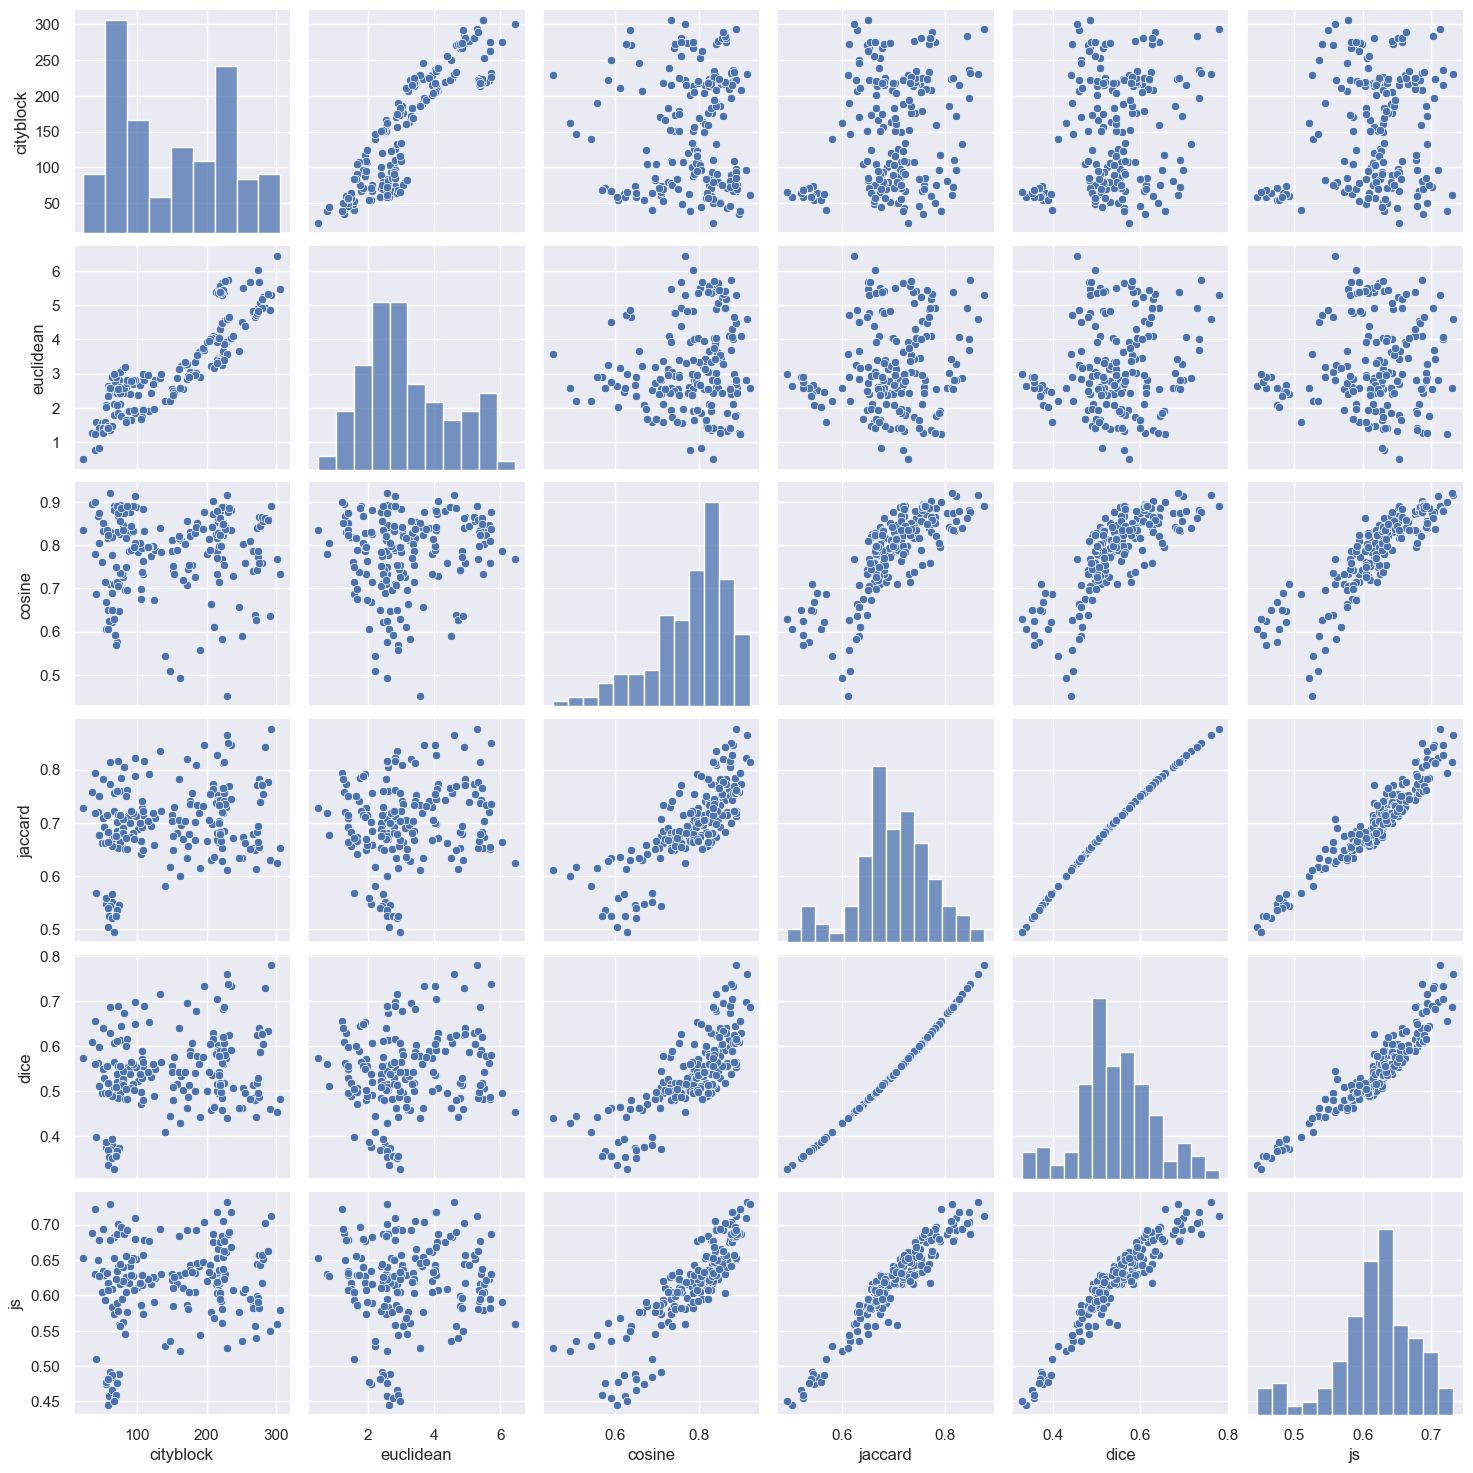

In [23]:
sns.pairplot(SAMPLE);

In [24]:
PAIRS.sort_values('cosine').head(20).style.background_gradient('YlGnBu')

# Create Clusters

## Hiearchical

In [25]:
def hca(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 10)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = LIB.label.values #DOC.title.values
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 640x480 with 0 Axes>

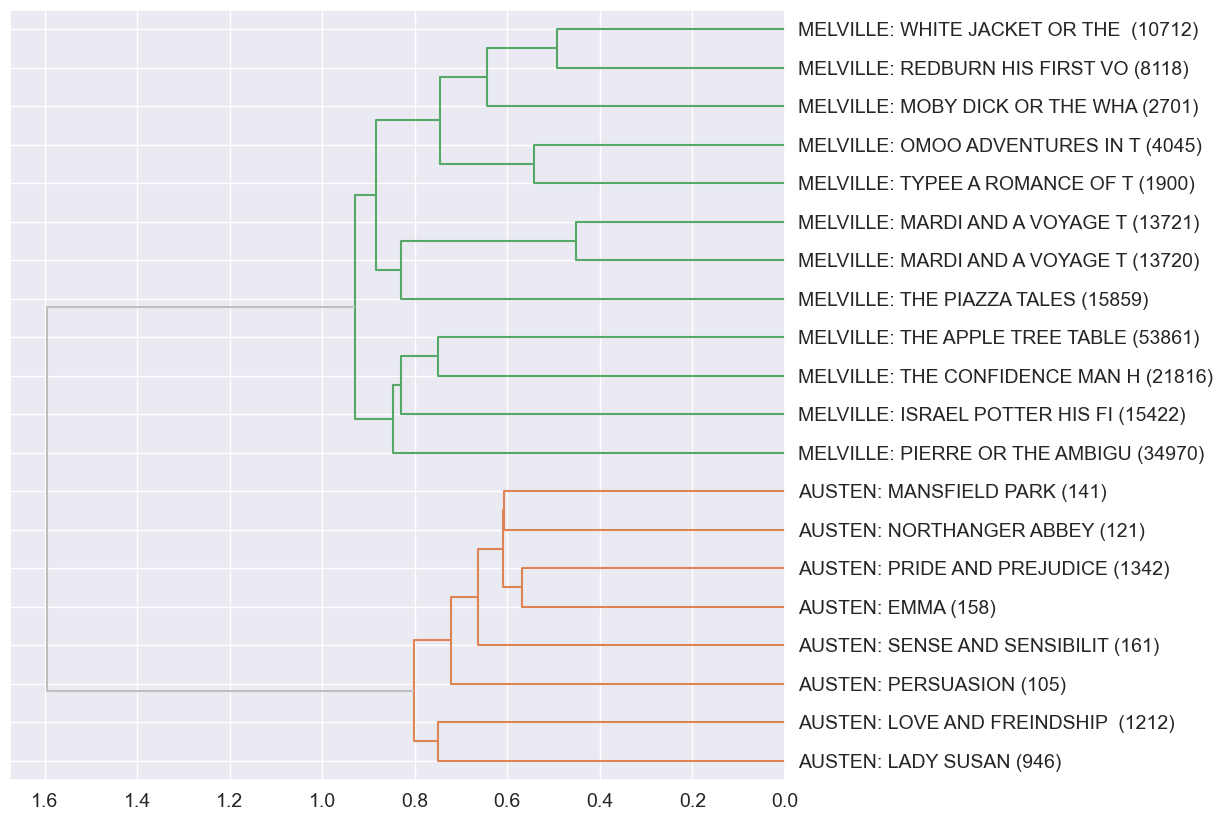

In [26]:
hca(PAIRS.cosine, linkage_method='ward', color_thresh=1);

<Figure size 640x480 with 0 Axes>

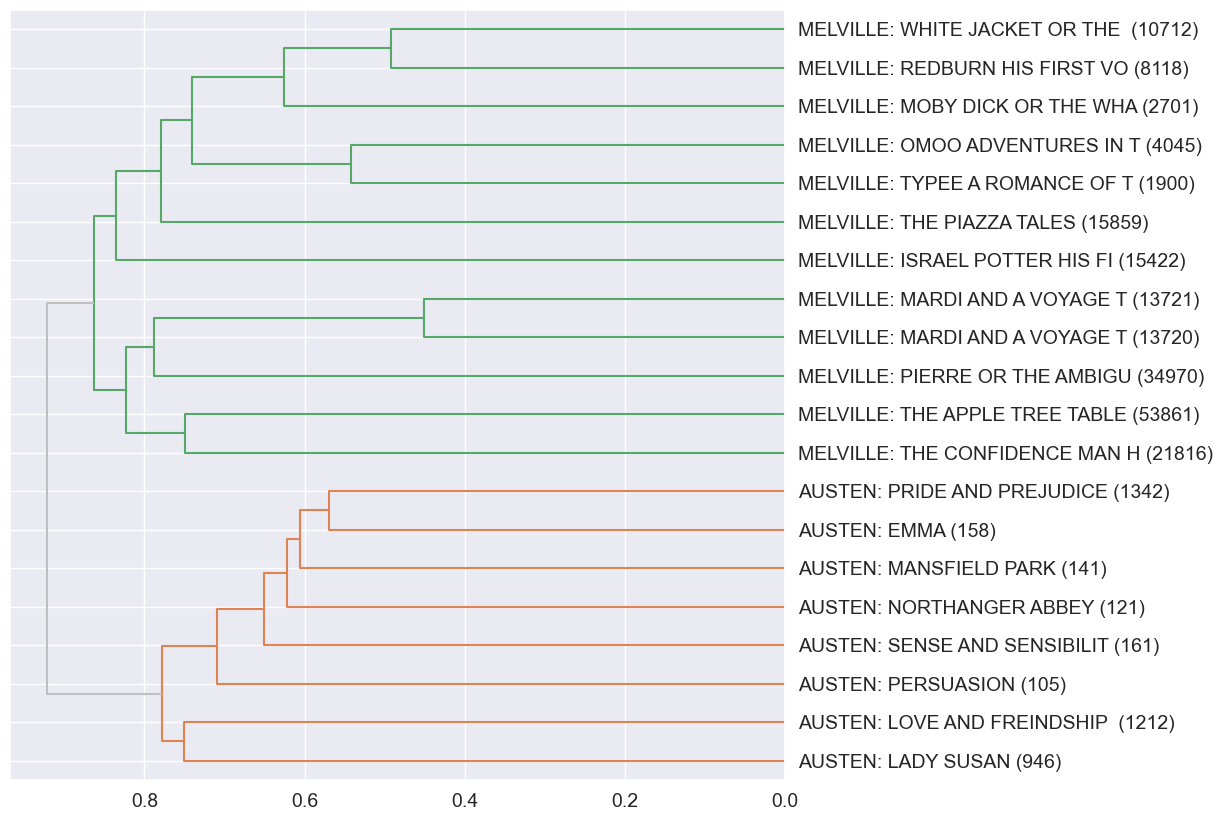

In [27]:
hca(PAIRS.cosine, linkage_method='complete', color_thresh=.9);

<Figure size 640x480 with 0 Axes>

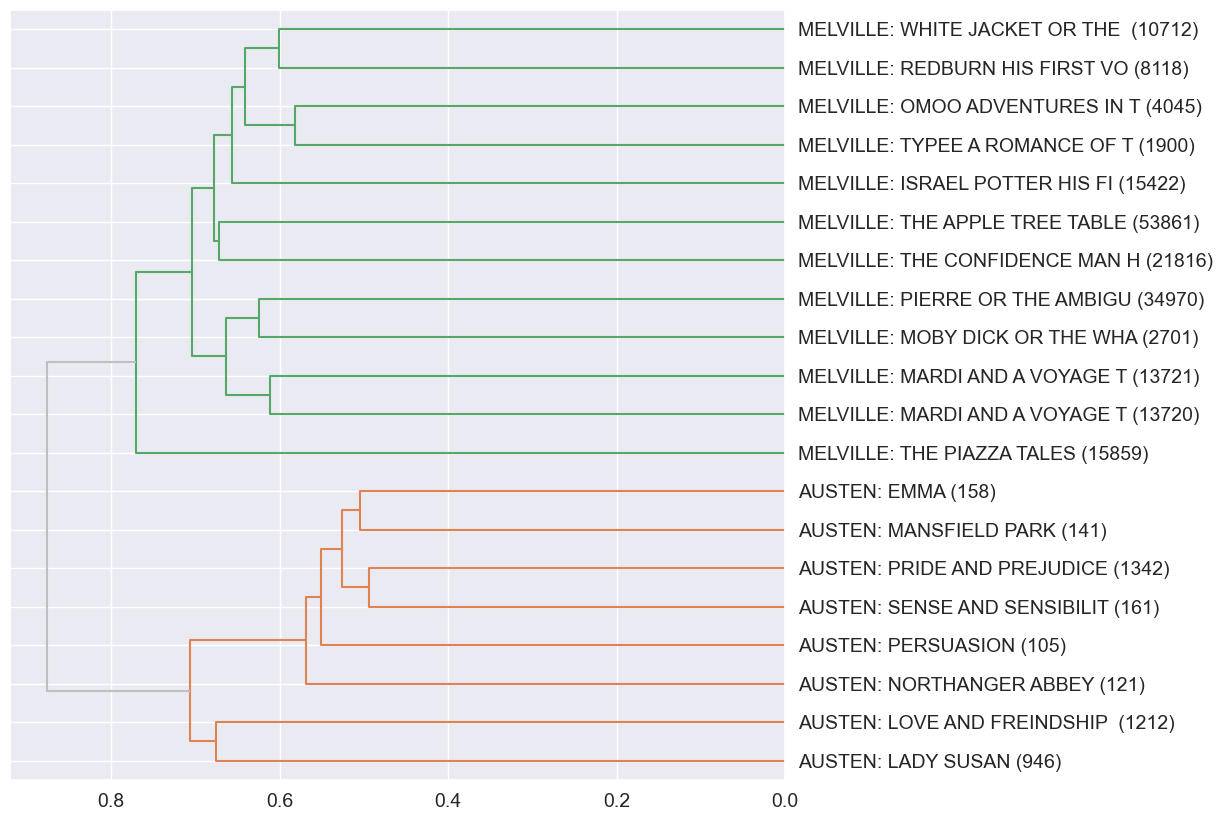

In [28]:
hca(PAIRS.jaccard, color_thresh=.8);

<Figure size 640x480 with 0 Axes>

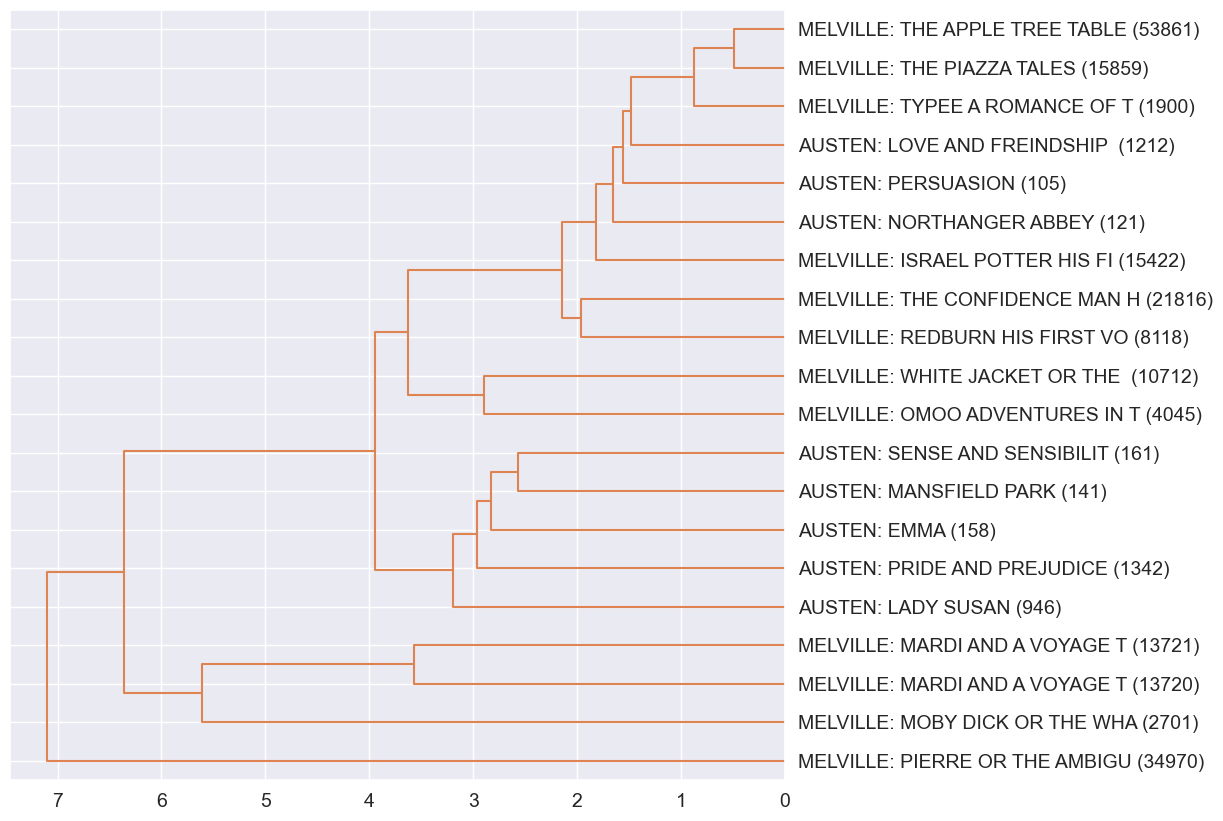

In [29]:
hca(PAIRS.euclidean, linkage_method='ward', color_thresh=80);

<Figure size 640x480 with 0 Axes>

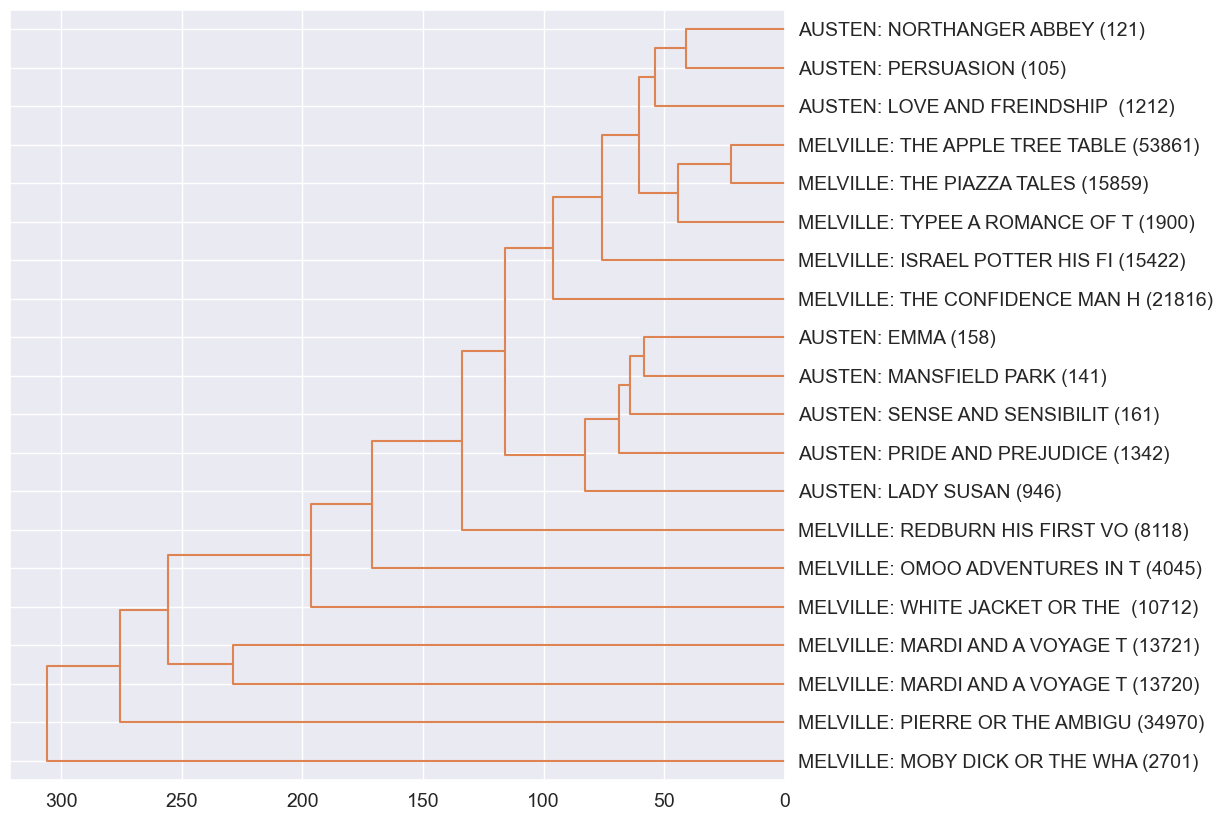

In [30]:
hca(PAIRS.cityblock, color_thresh=1300);

<Figure size 640x480 with 0 Axes>

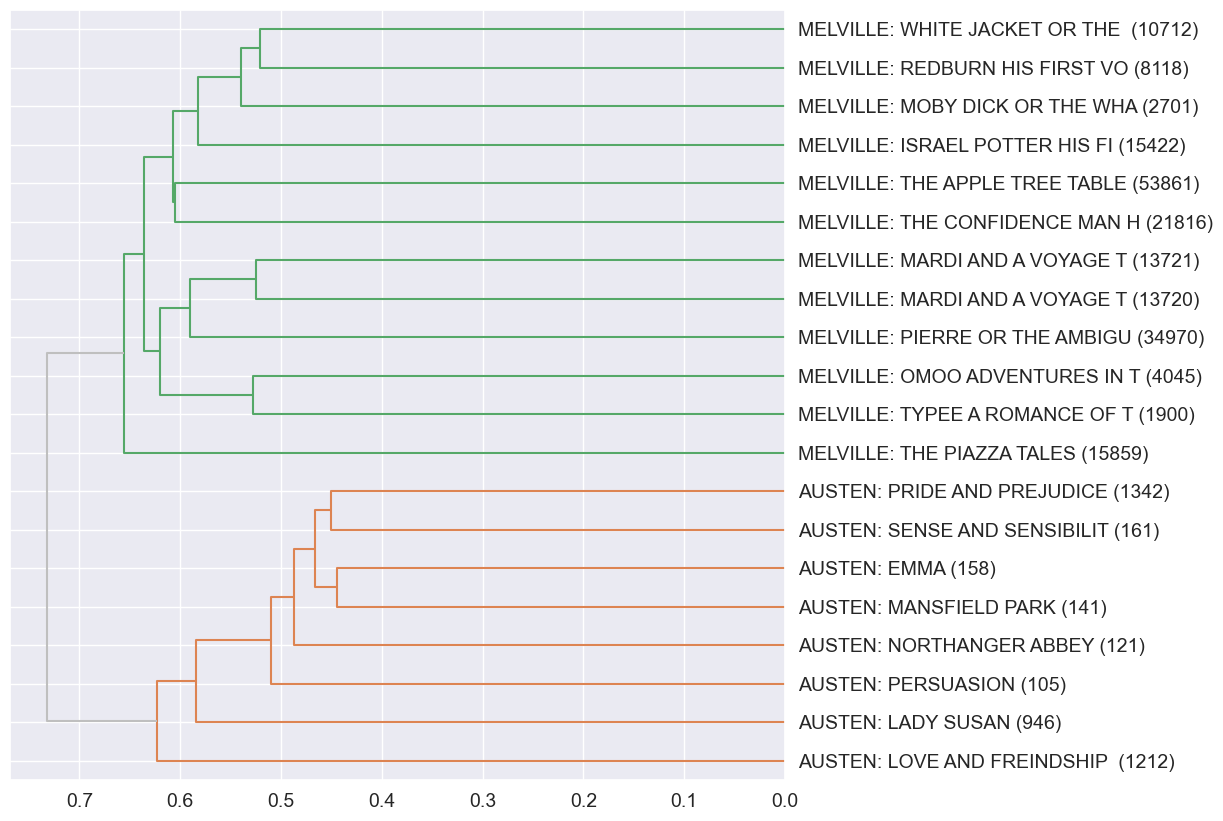

In [31]:
hca(PAIRS.js, color_thresh=.7);

## Questions

What distance measures produce the best results?

## K-Means

K-Means *only* uses Euclidean distance. Why?

* The K-Means procedure does not explicitly use pairwise distances between data points. 
* Instead, it repeatedly assigns points to the closest centroid thereby using Euclidean distance from data points to a centroid. 
* However, K-Means is *implicitly* based on pairwise Euclidean distances between data points, because the sum of squared deviations from centroid is equal to the sum of pairwise squared Euclidean distances divided by the number of points. 
* The term "centroid" is itself from Euclidean geometry. It is multivariate mean in Euclidean space. Euclidean space is about euclidean distances. Non-Euclidean distances will generally not span Euclidean space. That's why K-Means is for Euclidean distances only.

See the [Cross Validated](https://stats.stackexchange.com/questions/81481/why-does-k-means-clustering-algorithm-use-only-euclidean-distance-metric) post on this.

In [32]:
from sklearn.cluster import KMeans

In [33]:
n_clusters = 6

In [34]:
LIB['y_raw'] = KMeans(n_clusters).fit_predict(TFIDF)
LIB['y_L0'] = KMeans(n_clusters).fit_predict(L0)
LIB['y_L1'] = KMeans(n_clusters).fit_predict(L1)
LIB['y_L2'] = KMeans(n_clusters).fit_predict(L2)

In [58]:
y_cols = [col for col in LIB.columns if 'y_' in col]

In [59]:
LIB[['label'] + y_cols].sort_values('label').style.background_gradient('YlGnBu')

In [51]:
LIB[['label'] + y_cols].sort_values('y_L2')[['label', 'y_L2']].style.background_gradient('YlGnBu')

# Correlation Matrix

Use Pandas' `df.corr('kendall')` method to generate pairs. 

Correlation is normalized covariance, which is the dot product two vectors.

Kendall’s correlation is non-parametric -- it does not require the two variables have a bell curve distribution.

In [36]:
# TFIDF.T.corr?

In [37]:
# corr_type = 'pearson'
corr_type = 'kendall'
# corr_type = 'spearman'

In [38]:
CORR_MATRIX = TFIDF.T.corr(corr_type)

In [91]:
(CORR_MATRIX * 10).astype('int').style.background_gradient(cmap='YlGnBu', axis=None)

In [92]:
CORR = CORR_MATRIX.stack().to_frame(corr_type).sort_index()
CORR.index.names = ['doc_a', 'doc_b']
CORR = CORR.query('doc_a < doc_b')

<Figure size 640x480 with 0 Axes>

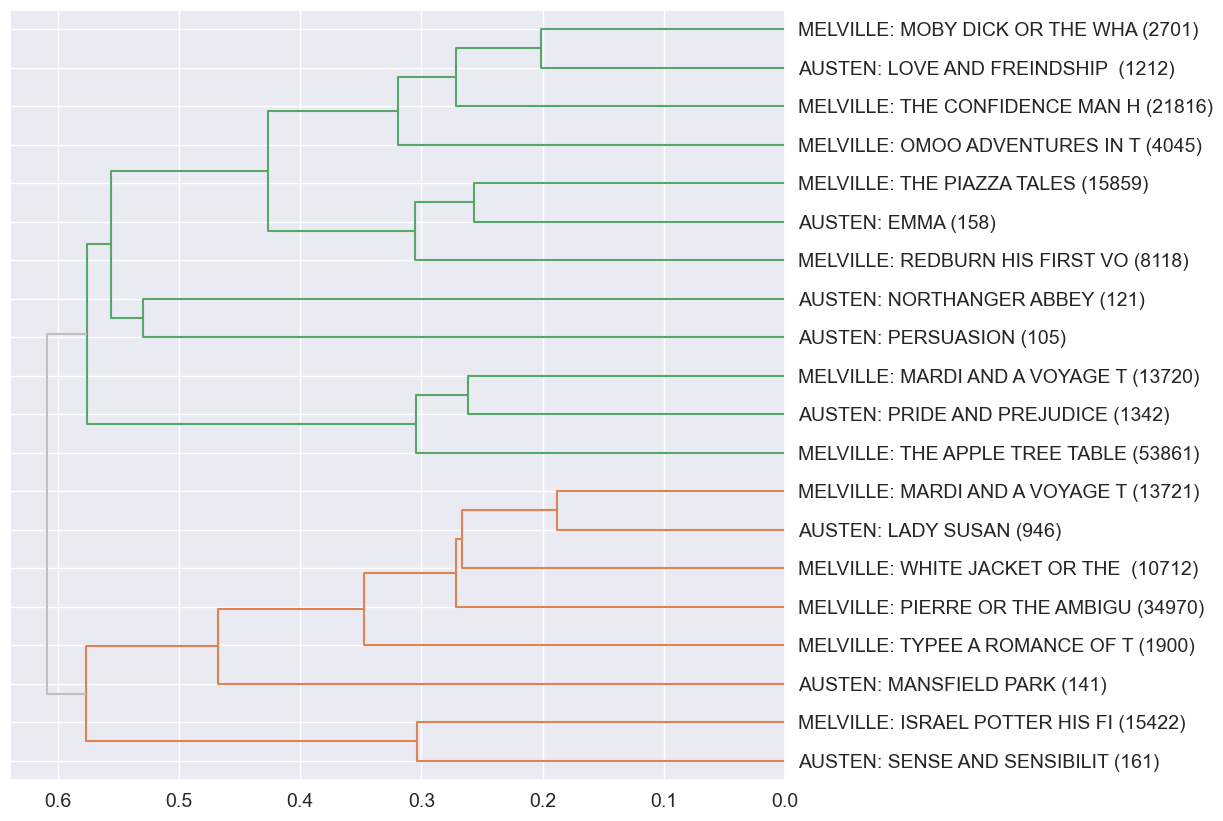

In [93]:
hca(CORR[corr_type], color_thresh=.6);

In [73]:
AUS_IDX = LIB[LIB.author.str.contains("AUS")].index.to_list()
MEL_IDX = LIB[LIB.author.str.contains("MEL")].index.to_list()

In [80]:
CORR_MATRIX.loc[AUS_IDX, AUS_IDX].stack().mean()

0.5775259055307203

In [82]:
CORR_MATRIX.loc[MEL_IDX, MEL_IDX].stack().mean()

0.3688715550847207

# Conclusions

* Cosine similarty with Ward Linkage for HAC seems best.
* L2 normalization for K-Means seems best.
* Correlation does not appear useful for grouping.
* More variance and entropy in Melville compared to Austen.

# Save Work

In [42]:
TFIDF.to_csv('{}/{}-TFIDF_book.csv'.format(data_out, data_prefix))
CORR.join(PAIRS).to_csv('{}/{}-DOCPAIRS.csv'.format(data_out, data_prefix))